In [34]:
import pandas as pd
from py_files.nadadinada import cust_basket, cust_info, prod_map
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
cust_info.head(3)

,Unnamed: 0,customer_id,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
0,0,39634,David Frink,male,05/15/1964 10:34 PM,1.0,1.0,1.0,2.0,18306.0,...,4056.0,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071
1,1,43460,Belinda Terry,female,03/26/1988 11:06 PM,1.0,0.0,1.0,2.0,5015.0,...,1925.0,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802
2,2,23937,Evelyn Calico,female,04/13/1969 06:07 PM,0.0,1.0,1.0,3.0,3097.0,...,2347.0,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105


In [3]:
cust_basket.head(3)

,invoice_id,list_of_goods,customer_id
0,7448187,"['olive oil', 'yogurt cake', 'grated cheese', ...",43134
1,3167314,"['babies food', 'shower gel', 'rice', 'black b...",43134
2,10199712,"['babies food', 'barbecue sauce', 'olive oil',...",43134


In [4]:
prod_map.head(3)

,product_name,category
0,champagne,alcohol_drinks
1,bramble,alcohol_drinks
2,white wine,alcohol_drinks


For initial exploration of the clusters we need to first do some basic preprocessing: 
- alter the columns where nan values mean something
- remove nan values
- remove categorical variables
- scale data

In [6]:
cust_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43631 entries, 0 to 43630
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Unnamed: 0                               43631 non-null  int64  
 1   customer_id                              43631 non-null  int64  
 2   customer_name                            43631 non-null  object 
 3   customer_gender                          43631 non-null  object 
 4   customer_birthdate                       43631 non-null  object 
 5   kids_home                                43107 non-null  float64
 6   teens_home                               42610 non-null  float64
 7   number_complaints                        42977 non-null  float64
 8   distinct_stores_visited                  42322 non-null  float64
 9   lifetime_spend_groceries                 43631 non-null  float64
 10  lifetime_spend_electronics               43631

#### Basic preprocessing explanation: 
- drop first column because it means nothing
- drop customer id, does not have business value
- drop customer name, categorical
- since bools vary the segmentation aggressively i will just remove gender as well
- i will not waste time converting birth date to age so will drop as well
- loyalty_card_number should be converted to a boolean but i will just remove it
- since latitude and longitude do not make sense to standardize and need to be analysed apart i will remove it 

In [27]:
cust_info_pp = cust_info.drop(columns=['Unnamed: 0', 'customer_id', 'customer_name', 'customer_gender',
                                       'customer_birthdate', 'loyalty_card_number', 'latitude', 'longitude'])

In [28]:
cust_info_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43631 entries, 0 to 43630
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   kids_home                                43107 non-null  float64
 1   teens_home                               42610 non-null  float64
 2   number_complaints                        42977 non-null  float64
 3   distinct_stores_visited                  42322 non-null  float64
 4   lifetime_spend_groceries                 43631 non-null  float64
 5   lifetime_spend_electronics               43631 non-null  float64
 6   typical_hour                             41886 non-null  float64
 7   lifetime_spend_vegetables                42758 non-null  float64
 8   lifetime_spend_nonalcohol_drinks         43631 non-null  float64
 9   lifetime_spend_alcohol_drinks            43631 non-null  float64
 10  lifetime_spend_meat                      43631

In [29]:
cust_info_pp.dropna(inplace=True)

In [30]:
cust_info_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36673 entries, 0 to 43630
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   kids_home                                36673 non-null  float64
 1   teens_home                               36673 non-null  float64
 2   number_complaints                        36673 non-null  float64
 3   distinct_stores_visited                  36673 non-null  float64
 4   lifetime_spend_groceries                 36673 non-null  float64
 5   lifetime_spend_electronics               36673 non-null  float64
 6   typical_hour                             36673 non-null  float64
 7   lifetime_spend_vegetables                36673 non-null  float64
 8   lifetime_spend_nonalcohol_drinks         36673 non-null  float64
 9   lifetime_spend_alcohol_drinks            36673 non-null  float64
 10  lifetime_spend_meat                      36673 non-

In [31]:
scaler = StandardScaler()

cust_info_pp_sc = scaler.fit_transform(cust_info_pp)

## Kmeans Clustering

In [35]:
dispersion = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(cust_info_pp_sc)
    dispersion.append(kmeans.inertia_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

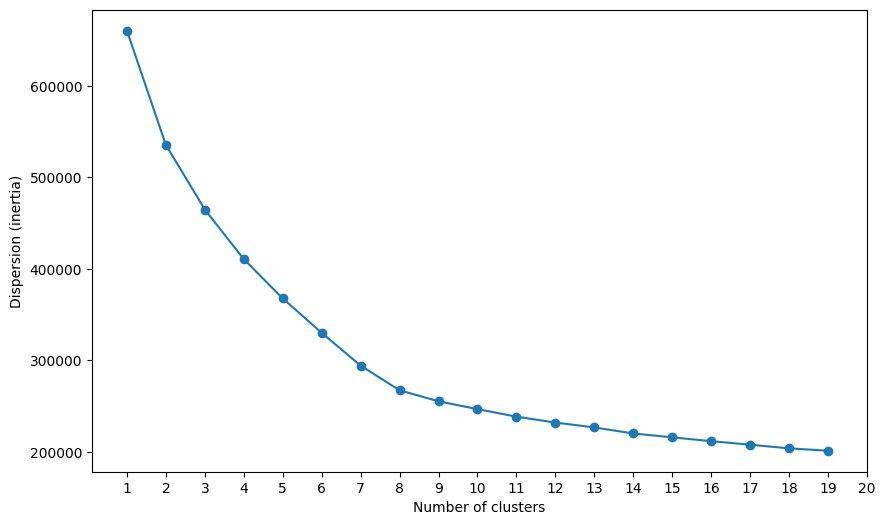

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), dispersion, marker='o')
plt.xticks(range(1, 21, 1))
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion (inertia)')
plt.show()

In this case, observing the elbow graph, we see that the dispersion decreases rapidly initially and then starts to level off. The point where this leveling off occurs, often resembling an elbow, suggests the optimal number of clusters. In the given graph, 8 seems to be a reasonable number of clusters as it corresponds to the point where the decrease in dispersion significantly slows down, indicating diminishing returns in clustering quality beyond this point. Therefore, based on the elbow method, 8 clusters appear to be a suitable choice for this dataset.

In [39]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(cust_info_pp_sc)
cust_info_pp['cluster_kmeans'] = kmeans.predict(cust_info_pp_sc)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [40]:
cust_info_pp.groupby(['cluster_kmeans']).mean()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction
cluster_kmeans,,,,,,,,,,,,,,,,,,
0,0.992553,0.454001,0.518692,1.249124,2934.525409,421.626898,13.716852,980.245181,313.990362,159.736419,69.636098,79.672459,500.929176,239.042786,510.893107,224.199620,0.197059,2011.011828
1,3.165256,2.079012,1.013933,1.121693,4979.858025,1986.321340,17.720459,498.388536,506.085538,308.696649,1003.114991,998.230159,992.744974,989.805820,990.216049,508.778483,0.198068,2011.008818
2,1.002000,0.835592,1.049767,1.997556,4929.270162,2030.989558,9.640080,306.152188,605.343257,987.432571,979.707843,1876.973339,1922.090647,970.791824,1887.965341,1040.272828,0.198821,2008.574983
3,1.002103,0.996426,0.496846,1.388562,13996.429773,8127.528806,13.664634,498.611228,596.272708,1018.764718,2002.231287,4002.635198,1997.196384,4001.148234,3001.441548,100.476871,0.049756,2011.160219
4,0.403674,0.207018,0.150495,1.519548,3228.704899,2127.855864,15.139661,265.912624,405.282619,853.276024,552.198540,704.162270,641.673340,683.608573,623.861517,399.660151,0.164499,2016.649317
5,0.000000,0.012161,0.505090,1.000000,10145.779977,160.136312,11.844174,199.260747,499.678167,40.179581,201.722285,202.791007,79.340498,0.000000,10013.732749,51.382353,0.198031,2011.036199
6,0.571471,0.996905,1.012673,3.034188,2070.600354,252.083996,12.288977,219.706749,310.151783,333.508252,418.867963,507.088270,501.871205,409.659593,596.453876,403.132626,0.485659,2010.805187
7,0.027273,0.033333,0.515152,1.000000,13826.200000,191.118182,10.012121,398.042424,309.196970,100.418182,83.866667,40152.900000,100.545455,0.000000,0.000000,19.890909,0.395863,2011.139394


In [41]:
cust_info_pp.mean()

kids_home                                     1.080386
teens_home                                    0.847899
number_complaints                             0.705042
distinct_stores_visited                       1.674720
lifetime_spend_groceries                   5597.671011
lifetime_spend_electronics                 1999.306929
typical_hour                                 13.515338
lifetime_spend_vegetables                   456.573037
lifetime_spend_nonalcohol_drinks            443.777466
lifetime_spend_alcohol_drinks               496.149047
lifetime_spend_meat                         709.645952
lifetime_spend_fish                        1474.895754
lifetime_spend_hygiene                      917.655878
lifetime_spend_videogames                   990.666458
lifetime_spend_petfood                     2017.580236
lifetime_total_distinct_products            387.235732
percentage_of_products_bought_promotion       0.229844
year_first_transaction                     2011.349494
cluster_km

Note: It is **very** important to compare clusters against the mean of the variables and not their relative difference in between clusters. The mean (or any other centrality measure) of the variable will give us an "anchor" that we can use when explaining why a certain "cluster" has a certain set of characteristics.

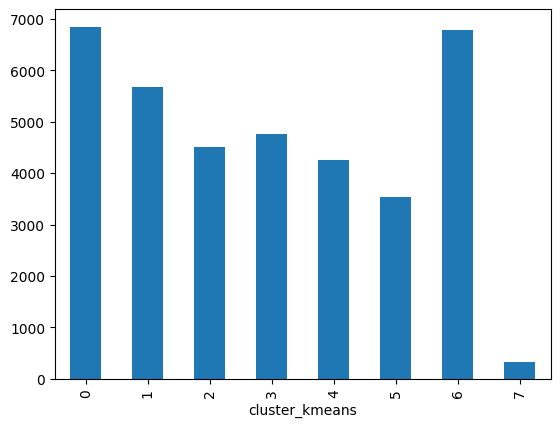

In [42]:
cust_info_pp.groupby(['cluster_kmeans']).size().plot(kind='bar')
plt.show()

## Hierarchical Clustering

agg_clust = AgglomerativeClustering(
    linkage='ward', distance_threshold=0, n_clusters=None
    ).fit(scaled_data)